In [17]:
from src.textclf_transformer import *

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16 if device == 'cuda' else torch.float32
print(f"Używane urządzenie: {device}, dtype: {dtype}")

Używane urządzenie: cuda, dtype: torch.float16


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

Używane urządzenie: cuda, dtype: torch.float16

Rozpoczęcie porównania dla N od 500 do 20000 z krokiem 1000.
Testowanie N = 500...
  FAVOR+ (Twoja Impl.)          : 3.9541 ms
  LSH Attn (Twoja Impl.)        : 9.0726 ms
  SDPA (FlashAttn - Native)     : 0.0802 ms
Testowanie N = 1500...
  FAVOR+ (Twoja Impl.)          : 1.8805 ms
  LSH Attn (Twoja Impl.)        : 3.5337 ms
  SDPA (FlashAttn - Native)     : 0.4828 ms
Testowanie N = 2500...
  FAVOR+ (Twoja Impl.)          : 1.9629 ms
  LSH Attn (Twoja Impl.)        : 4.6511 ms
  SDPA (FlashAttn - Native)     : 1.1202 ms
Testowanie N = 3500...
  FAVOR+ (Twoja Impl.)          : 2.8532 ms
  LSH Attn (Twoja Impl.)        : 6.2864 ms
  SDPA (FlashAttn - Native)     : 2.0895 ms
Testowanie N = 4500...
  FAVOR+ (Twoja Impl.)          : 4.0362 ms
  LSH Attn (Twoja Impl.)        : 8.5158 ms
  SDPA (FlashAttn - Native)     : 3.4559 ms
Testowanie N = 5500...
  FAVOR+ (Twoja Impl.)          : 5.3962 ms
  LSH Attn (Twoja Impl.)        : 10.0657 ms
  SDP

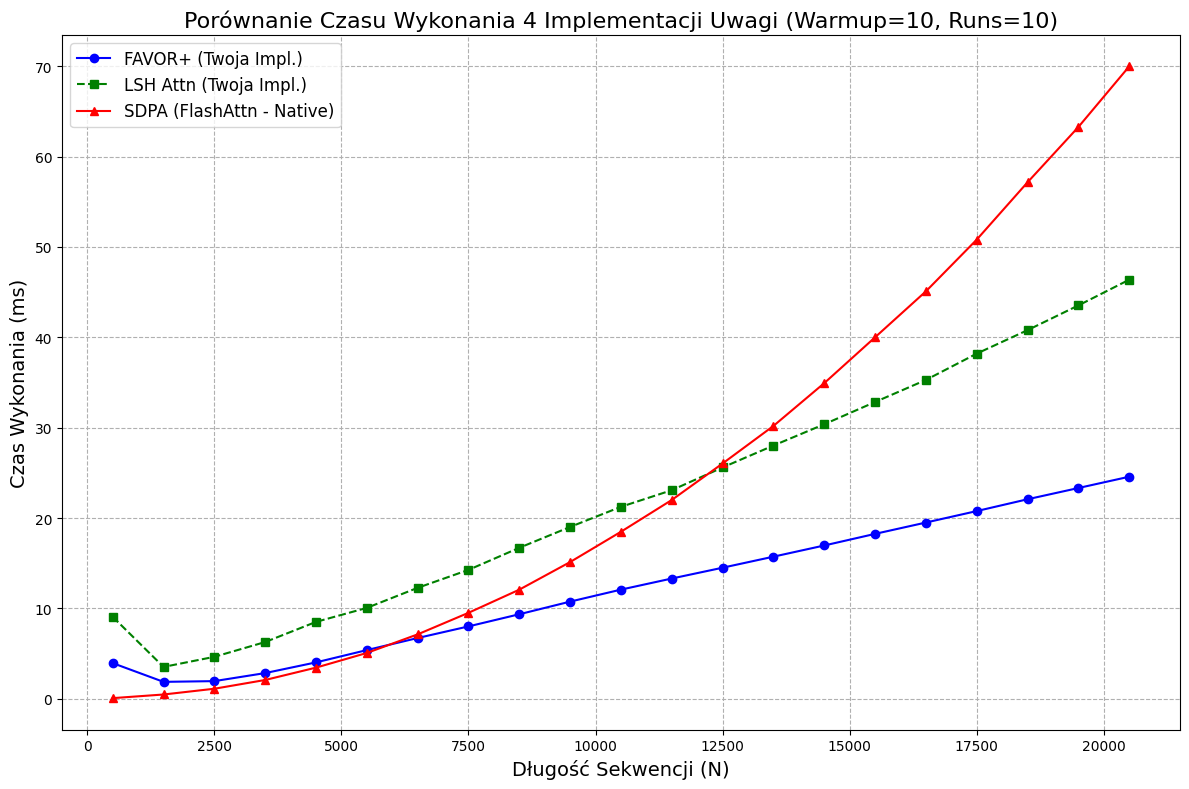

In [ ]:
# Ustawienia Globalne
EMBED_DIM = 128
ATTN_EMBED_DIM = 128
NUM_HEADS = 8
BATCH_SIZE = 2
NUM_WARMUP = 10
NUM_RUNS = 10
HEAD_DIM = EMBED_DIM // NUM_HEADS

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16 if device == 'cuda' else torch.float32
print(f"Używane urządzenie: {device}, dtype: {dtype}")



favor = AttentionBlock(
    embedding_dim=EMBED_DIM, attention_embedding_dim=ATTN_EMBED_DIM, num_heads=NUM_HEADS, projection_bias=True, 
    attn_dropout=0.0, out_dropout=0.0, attention_kind='favor',
    attention_params={'nb_features': 64, 'redraw_interval': 0, 'ortho_features': True, 'phi': 'exp', 'stabilize': True, 'eps': 1.0e-6}
).to(device).to(dtype).eval()

lsh = AttentionBlock(
    embedding_dim=EMBED_DIM, attention_embedding_dim=ATTN_EMBED_DIM, num_heads=NUM_HEADS, projection_bias=True, 
    attn_dropout=0.0, out_dropout=0.0, attention_kind='lsh',
    attention_params={'num_hashes': 2, 'chunk_size': 64, 'mask_within_chunks': True}
).to(device).to(dtype).eval()

# standard = AttentionBlock(
#     embedding_dim=512, attention_embedding_dim=512, num_heads=8, projection_bias=True, 
#     attn_dropout=0.0, out_dropout=0.0, attention_kind='mha',
#     attention_params={}
# ).to(device).to(dtype).eval()


# ==============================================================================
# 2. FUNKCJE POMOCNICZE
# ==============================================================================

def run_sdpa_native(Q_b: torch.Tensor):
    """Bezpośrednie wywołanie F.scaled_dot_product_attention (natywny FlashAttention)."""
    B, N, D = Q_b.shape

    # Przekształcenie do formatu (B, H, N, D/H)

    def transform_for_sdpa(tensor):
        return tensor.view(B, N, NUM_HEADS, HEAD_DIM).transpose(1, 2)
    
    Q_sdpa = transform_for_sdpa(Q_b)
    K_sdpa = transform_for_sdpa(Q_b)
    V_sdpa = transform_for_sdpa(Q_b)

    # Wywołanie SDPA - nie używamy maski paddingu ani look-ahead w tym teście
    output = F.scaled_dot_product_attention(Q_sdpa, K_sdpa, V_sdpa)
    return output.transpose(1, 2).contiguous().view(B, N, D)

def generate_tensors(seq_len: int, device, dtype):
    """Generuje tensory (Q=K=V) i maskę paddingu."""
    Q = torch.randn(BATCH_SIZE, seq_len, EMBED_DIM, device=device, dtype=dtype)
    key_padding_mask = torch.rand(BATCH_SIZE, seq_len, device=device) < 0.1
    return Q, key_padding_mask

def time_run(func, Q_b, key_padding_mask, num_runs, num_warmup):
    """Przeprowadza rozgrzewkę i mierzy czas uśredniony (ms)."""
    if device == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    # WARMUP
    for _ in range(num_warmup):
        _ = func(Q_b, key_padding_mask)
    if device == 'cuda':
        torch.cuda.synchronize()

    # POMIAR
    if device == 'cuda':
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        for _ in range(num_runs):
            _ = func(Q_b, key_padding_mask)
        end_event.record()
        torch.cuda.synchronize()
        total_time_ms = start_event.elapsed_time(end_event)
    else:
        start_time = time.time()
        for _ in range(num_runs):
            _ = func(Q_b, key_padding_mask)
        total_time_ms = (time.time() - start_time) * 1000

    return total_time_ms / num_runs

SEQ_LEN_START = 500
SEQ_LEN_END = 20000
SEQ_LEN_STEP = 1000
SEQ_LEN_LIST = list(range(SEQ_LEN_START, SEQ_LEN_END + SEQ_LEN_STEP, SEQ_LEN_STEP))

results = {
    "FAVOR+ (Twoja Impl.)": [],
    "LSH Attn (Twoja Impl.)": [],
    "SDPA (FlashAttn - Native)": []
}

implementations = {
    "FAVOR+ (Twoja Impl.)": lambda q, kpm: favor(q, key_padding_mask=kpm),
    "LSH Attn (Twoja Impl.)": lambda q, kpm: lsh(q, key_padding_mask=kpm),
    "SDPA (FlashAttn - Native)": lambda q, kpm: run_sdpa_native(q)
}

print(f"\nRozpoczęcie porównania dla N od {SEQ_LEN_START} do {SEQ_LEN_END} z krokiem {SEQ_LEN_STEP}.")

with torch.no_grad():
    for seq_len in SEQ_LEN_LIST:
        print(f"Testowanie N = {seq_len}...")

        Q_b, key_padding_mask = generate_tensors(seq_len, device, dtype)

        for name, func in implementations.items():
            kpm_to_pass = key_padding_mask if "Native" not in name else None # Nie przekazujemy maski do F.sdpa
 

            avg_time = time_run(func, Q_b, kpm_to_pass, NUM_RUNS, NUM_WARMUP)
            
            results[name].append(avg_time)
            print(f"  {name:<30}: {avg_time:.4f} ms")

print("\n--- Zakończono pomiary ---")

plt.figure(figsize=(12, 8))

for name, times in results.items():
    valid_times = [times[i] for i, x in enumerate(times) if not np.isnan(x)]
    valid_seq_lens = [SEQ_LEN_LIST[i] for i, x in enumerate(times) if not np.isnan(x)]
    
    # Dodanie stylów dla lepszej czytelności
    if "FAVOR" in name:
        style = {'color': 'blue', 'linestyle': '-', 'marker': 'o'}
    elif "LSH" in name:
        style = {'color': 'green', 'linestyle': '--', 'marker': 's'}
    elif "SDPA" in name:
        style = {'color': 'red', 'linestyle': '-', 'marker': '^'}
    else:
        style = {'color': 'orange', 'linestyle': ':', 'marker': 'D'}
        
    plt.plot(valid_seq_lens, valid_times, **style, label=name)
    

plt.title(f'Porównanie Czasu Wykonania 4 Implementacji Uwagi (Warmup={NUM_WARMUP}, Runs={NUM_RUNS})', fontsize=16)
plt.xlabel('Długość Sekwencji (N)', fontsize=14)
plt.ylabel(f'Czas Wykonania (ms)', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()